In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import scipy.stats
import os

In [39]:
datapath = '/home/lautaro/Workspace/ib/code/codedoc/realdata/redes/FAO'
os.listdir(datapath)

['FAOSTAT_A-S_E',
 'FAO_manlio',
 'edges.csv',
 'coordinate-countries-fixed.csv',
 'gprops copy.csv',
 'nodes-fixed.csv',
 'gprops.csv',
 'ordered_nodes.csv',
 'not_nodes.csv',
 'gprops-fixed.csv',
 'nodes.csv',
 'FAOSTAT_T-Z_E']

In [40]:
products = eval(open(os.path.join(datapath, "gprops-fixed.csv")).read())

def get_edges_by_layer(layer=0):
    all_edges = pd.read_csv(os.path.join(datapath, "edges.csv"))
    all_edges = all_edges.rename(
        columns={
            "# source": "source",
            " target": "target",
            " weight": "weight",
            " layer": "layer",
        }
    )

    unique_count = all_edges[["source", "target"]].values.flatten()
    unique_count = len(set(unique_count))

    one_layer_edges = all_edges[all_edges["layer"] == layer + 1]
    # Saco cuando source = target (que onda esto?)
    one_layer_edges = one_layer_edges[
        one_layer_edges["source"] != one_layer_edges["target"]
    ]
    # Filtro los paises que no estan en el dataframe (los que no tienen coordenadas)
    # one_layer_edges = one_layer_edges[one_layer_edges['source'].isin(merged_nodes['index']) & one_layer_edges['target'].isin(merged_nodes['index'])]

    del all_edges
    return one_layer_edges

In [198]:
def weight_distribution(weights, product='all', n_bins=200, scale=None, type='bar'):
    fig, ax = plt.subplots(dpi=150)
    ax.set_title(product)
    ax.set_xlabel('w')
    bins = np.linspace(0, scale, n_bins) if scale else np.linspace(0, int(np.mean(weights)), n_bins)
    ax.hist(weights, bins=bins, histtype=type);

def log_weight_distribution(weights, product='all', n_bins=50, scale=7, cumulative=False, type='bar'):
    fig, ax = plt.subplots(dpi=150)
    ax.set_title(product)
    ax.set_xlabel('w')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # logbins = range(0, 10**scale, n_bins) if cumulative else np.logspace(0, scale, n_bins)
    logbins = np.logspace(0, scale, n_bins)
    ax.hist(weights, bins=logbins, cumulative=cumulative, histtype=type);

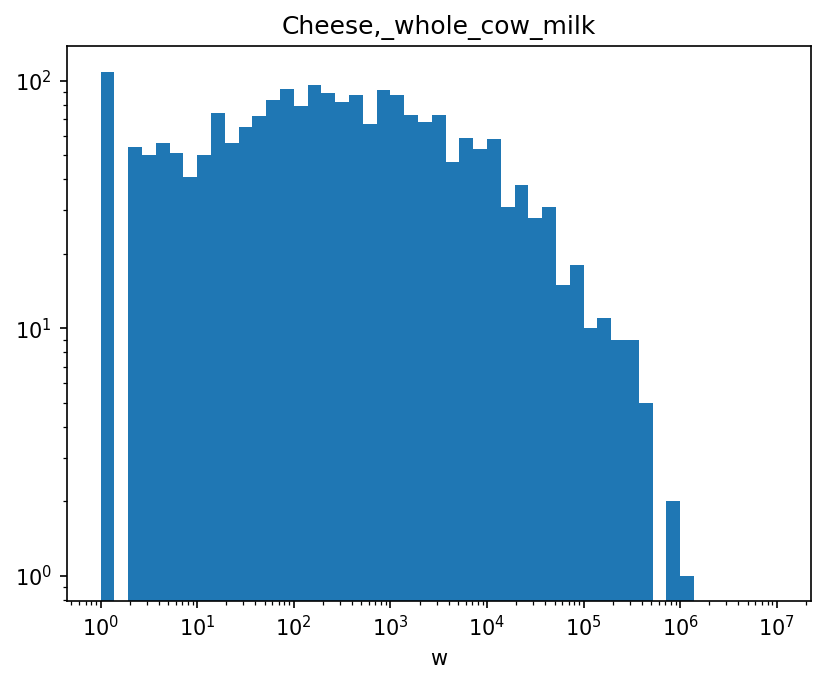

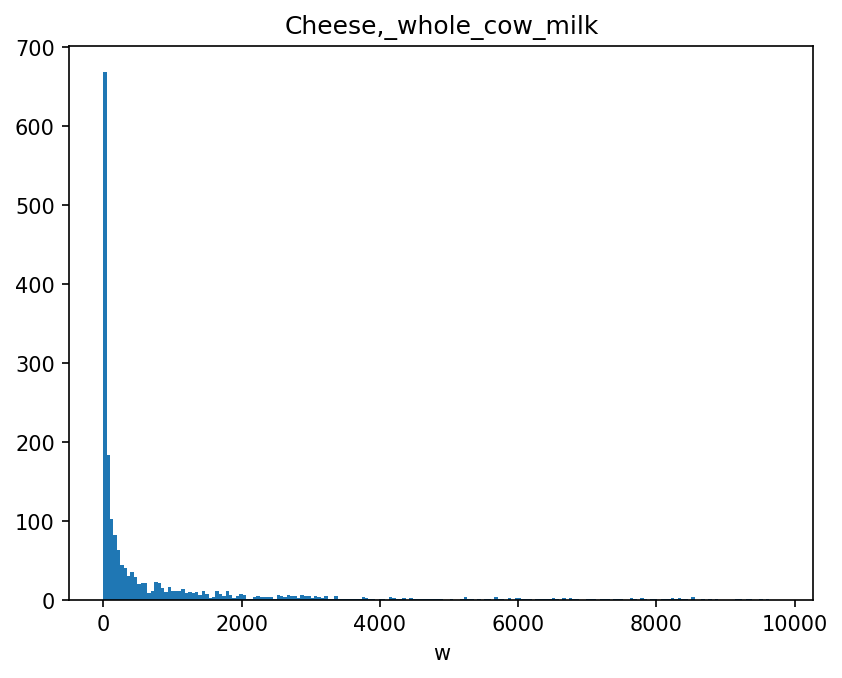

In [138]:
layer = 3
df = get_edges_by_layer(layer=layer)
log_weight_distribution(df['weight'], products[layer])
weight_distribution(df['weight'], products[layer])

In [43]:
full_dataset = [get_edges_by_layer(layer) for layer in products.keys()]

In [56]:
means = [np.mean(data['weight']) for data in full_dataset]
print(products[means.index(np.min(means))],'\t',  np.min(means))
print(products[means.index(np.max(means))],'\t', np.max(means))

Pyrethrum,_extraction 	 2.0
Soybeans 	 75486.97273718647


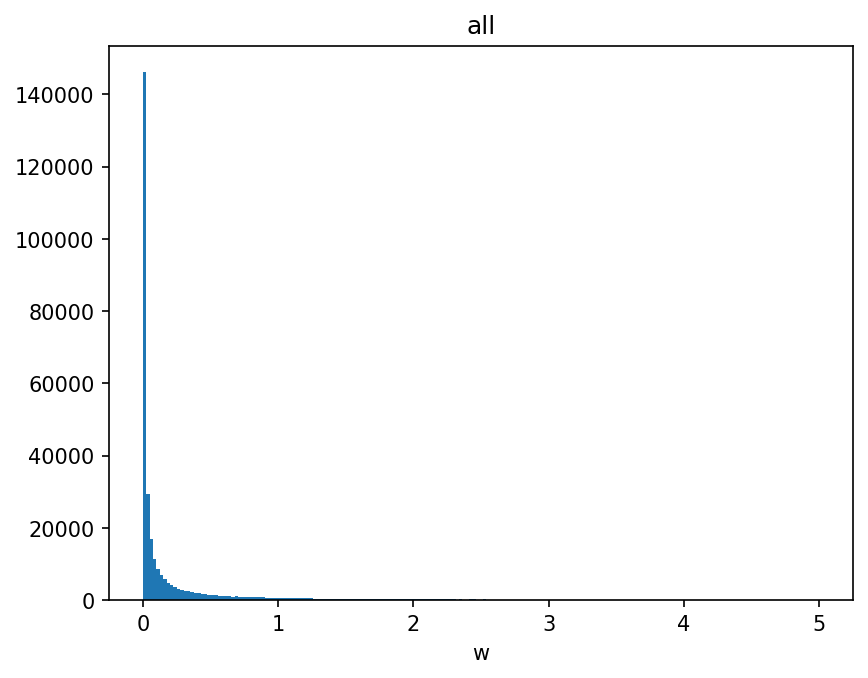

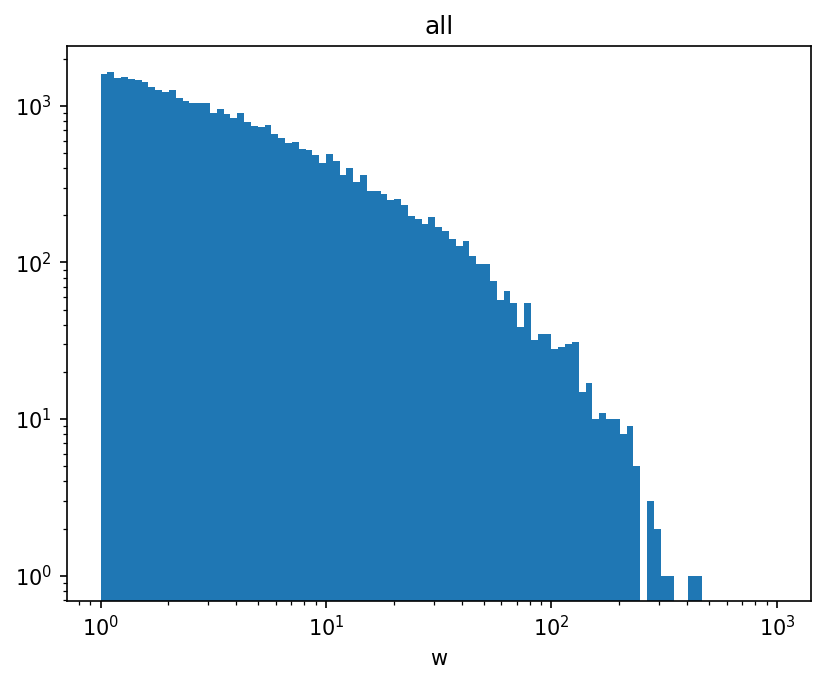

In [203]:
all_weights = [full_dataset[layer]['weight'] / np.mean(full_dataset[layer]['weight']) for layer in products.keys()] 
all_weights = [item for row in all_weights for item in row]

weight_distribution(all_weights, n_bins=200, scale=5)
log_weight_distribution(all_weights, n_bins=100, scale=3)

del all_weights

### Calculemos la 'fuerza' de los nodos

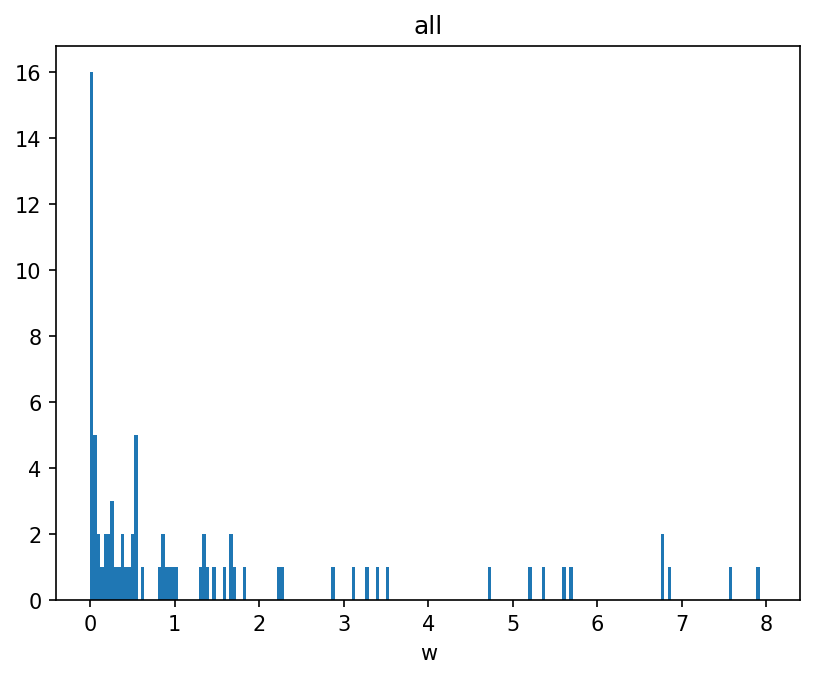

In [140]:
layer = 20
df = get_edges_by_layer(layer)
df['weight'] /= np.mean(df['weight'])

# Group by 'source' and sum the 'weight' column
grouped = df.groupby('source')['weight'].sum()
# Convert the grouped Series to a dictionary
export_strength = grouped.to_dict()

grouped = df.groupby('target')['weight'].sum()
# Convert the grouped Series to a dictionary
import_strength = grouped.to_dict()

weight_distribution(list(import_strength.values()))

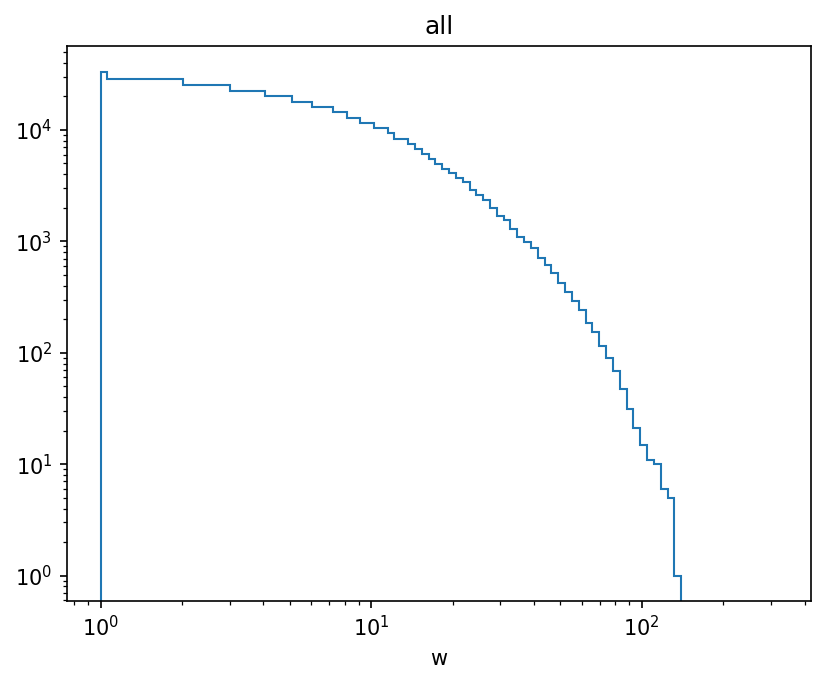

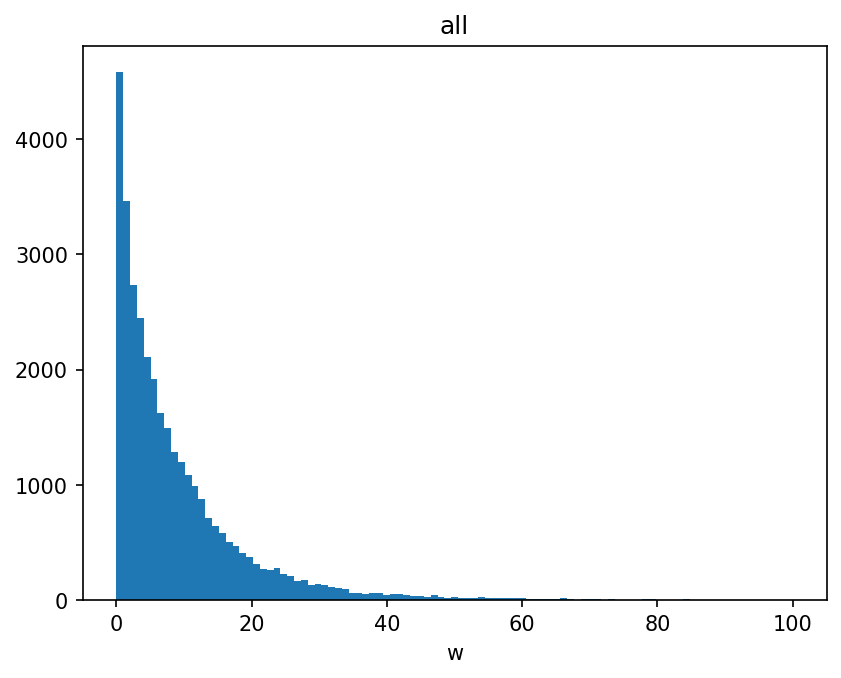

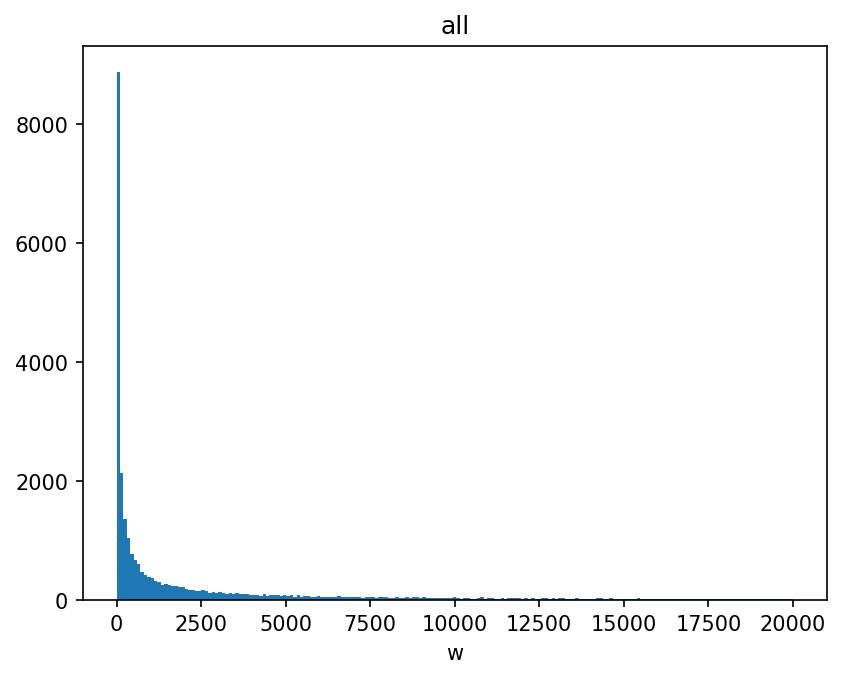

In [202]:
all_data = [full_dataset[layer] for layer in products.keys()] 

# Group by 'source' and sum the 'weight' column
# import_grouped = [data.groupby('target')['weight'].sum() / np.mean(data['weight']) for data in all_data]
# export_grouped = [data.groupby('source')['weight'].sum() / np.mean(data['weight']) for data in all_data]
# Sin normalizar?
import_grouped = [data.groupby('target')['weight'].sum()  for data in all_data]
import_grouped_neighs = [data.groupby('target')['weight'].count()  for data in all_data]
export_grouped = [data.groupby('source')['weight'].sum()  for data in all_data]

# Totales por producto, el histograma es el de todos los productos juntos
import_total = [item for row in import_grouped for item in row]
import_total_neighs = [item for row in import_grouped_neighs for item in row]
export_total = [item for row in export_grouped for item in row]

del import_grouped, import_grouped_neighs, export_grouped

# log_weight_distribution(import_total, n_bins=200, scale=7, cumulative=False)
log_weight_distribution(import_total_neighs, n_bins=100, scale=2.5, cumulative=-1, type='step')
weight_distribution(import_total_neighs, n_bins=100, scale=100)
weight_distribution(import_total, scale=20000)

In [2]:
# Paso de latitud/longitud a coordenadas x, y en la proy. Mercator (en km)
def merc_from_arrays(lats, lons):
    r_major = 6378.137000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return np.vstack((x, y)).T

In [3]:
def get_data(layer=0, info=False):
    coords = pd.read_csv('coordinate-countries-fixed.csv')
    coords = coords.rename(columns={'ISO 3166 Country Code': 'Code'})
    
    coordinates = merc_from_arrays(coords['Latitude'], coords['Longitude'])
    coords['x'] = coordinates[:, 0]
    coords['y'] = coordinates[:, 1]

    # Pongo a mano el codigo de Namibia porque anda mal
    coords.loc[coords['Country'] == 'Namibia', 'Code'] = 'NA'

    prods = eval(open("gprops-fixed.csv").read())

    nodes = pd.read_csv('nodes-fixed.csv')
    nodes = nodes.rename(columns={'# index': 'index', ' name': 'name'})
    nodes = nodes.drop(columns=[' nodeLabel', ' _pos'])
    # Reemplazo '_' con ' ' para que matcheen mas paises
    nodes['name'] = nodes['name'].str.replace('_', ' ')

    # Merge DataFrames A and B based on matching country names
    merged_nodes = pd.merge(coords, nodes, left_on='Country', right_on='name')

    # Filter and sort the merged DataFrame
    merged_nodes = merged_nodes[['index', 'Country', 'Code', 'Latitude', 'Longitude', 'x', 'y']].sort_values(by='index')
    merged_nodes.reset_index(drop=True, inplace=True)


    all_edges = pd.read_csv('edges.csv')
    all_edges = all_edges.rename(columns={'# source': 'source', ' target': 'target', ' weight': 'weight', ' layer': 'layer'})

    unique_count = all_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    # Filtro solo un layer
    one_layer_edges = all_edges[all_edges['layer'] == layer+1]
    # Saco cuando source = target (que onda esto?)
    one_layer_edges = one_layer_edges[one_layer_edges['source'] != one_layer_edges['target']]
    # Filtro los paises que no estan en el dataframe (los que no tienen coordenadas)
    one_layer_edges = one_layer_edges[one_layer_edges['source'].isin(merged_nodes['index']) & one_layer_edges['target'].isin(merged_nodes['index'])]

    unique_count = one_layer_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    if info:
        print(f"Layer {layer}: {prods[layer]}\nNumber of countries:", unique_count)

    filtered_nodes = merged_nodes[merged_nodes['index'].isin(one_layer_edges['source']) | merged_nodes['index'].isin(one_layer_edges['target'])]

    G = nx.from_pandas_edgelist(one_layer_edges, source= 'source', target = 'target')

    pos = {node : [filtered_nodes.loc[filtered_nodes['index'] == node, 'x'].values[0], filtered_nodes.loc[filtered_nodes['index'] == node, 'y'].values[0]] for node in filtered_nodes['index']}
    
    
    codes = {node : filtered_nodes.loc[filtered_nodes['index'] == node, 'Code'].values[0] for node in filtered_nodes['index']}
    
    nx.set_node_attributes(G, pos, 'pos')
    nx.set_node_attributes(G, codes, 'code')

    return G, filtered_nodes

def draw(G):
    pos = nx.get_node_attributes(G, 'pos')
    codes = nx.get_node_attributes(G, 'code')
    pos_text = {i: [v[0], v[1] - 350] for i, v in pos.items()}
    fig, ax = plt.subplots(figsize=(15,8))
    nx.draw_networkx_labels(G, pos_text, codes, font_size=10)
    nx.draw(G, pos=pos, node_size=40, width=.15, ax=ax)

Layer 135: Bulgur
Number of countries: 34


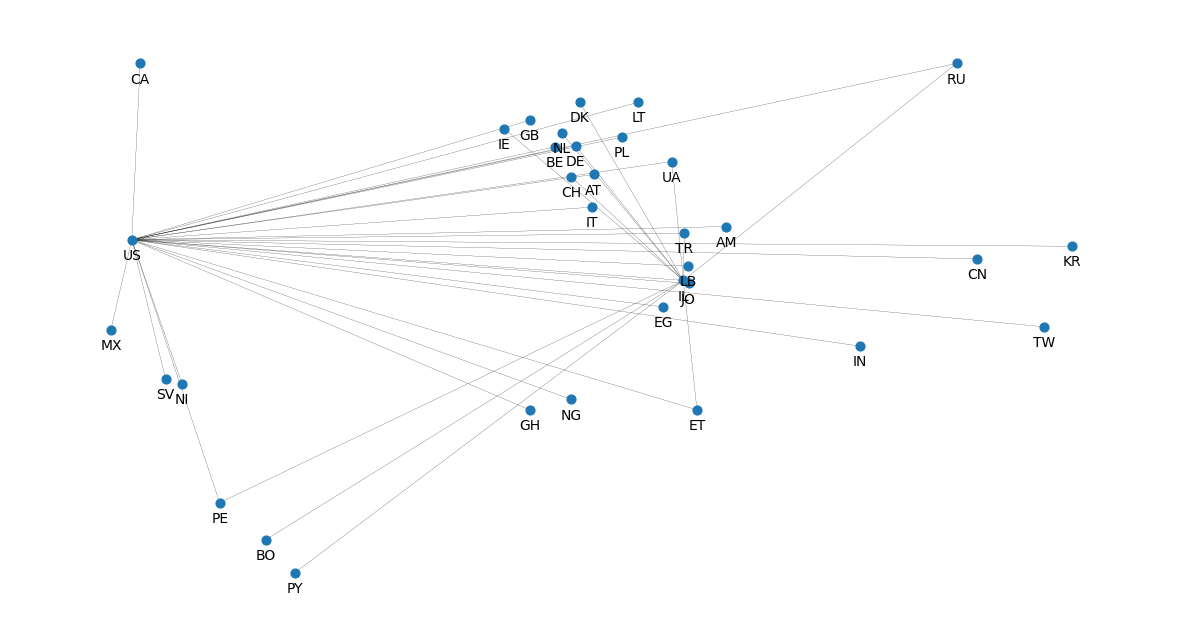

In [7]:
# Diccionario con el nombre de los productos
prods = eval(open("gprops-fixed.csv").read())

G, filtered_nodes = get_data(layer=135, info=True)

draw(G)

### Ahora podemos hacer un poco de histogramas y estadistica con las distintas layers

In [11]:
def get_mean_connectivity(G):
        return np.mean(list(dict(nx.degree(G)).values()))

def get_average_distance(G):
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G0 = G.subgraph(Gcc[0])
        return nx.average_shortest_path_length(G0)

def get_neighbors(G):
        return np.array(list(dict(nx.degree(G)).values()))

def plot_p_k(n_neighs, layer):
        fig, ax = plt.subplots(dpi=150)
        ax.set_title(prods[layer])
        ax.set_xlabel('k')
        ax.hist(n_neighs, bins=range(max(n_neighs)+1));
        # ax.set_xscale('log')
        # ax.set_yscale('log')

In [12]:
layers = prods.keys()

graphs = [get_data(layer)[0] for layer in layers]

In [13]:
connectivity = [get_mean_connectivity(G) for G in graphs]
distance = [get_average_distance(G) for G in graphs]
n_nodes = [G.number_of_nodes() for G in graphs]
n_neighs = [get_neighbors(G) for G in graphs]